In [16]:
import os
import pandas as pd
from itertools import product
import numpy as np
import pypsa

def get_filename(root_dir, combo, weekend=True):
    daytype = "WE" if weekend else "WD"
    if combo:
        combo_str = "_".join(combo)
        filename = f"Base_load_{daytype}_{combo_str}_aggregated.csv"
    else:
        filename = f"Base_load_{daytype}_aggregated.csv"
    return os.path.join(root_dir, filename)

def generate_scenario_profiles(hp_share, ev_share, pv_share, root_dir, weekend=True, insulation="current"):
    total_houses = 40
    tech_targets = {
        "HP": int(total_houses * hp_share),
        "EV": int(total_houses * ev_share),
        "PV": int(total_houses * pv_share)
    }

    house_assignments = []
    remaining = tech_targets.copy()
    remaining_houses = total_houses

    tech_combinations = [
        (), ("HP",), ("EV",), ("PV",),
        ("HP", "EV"), ("HP", "PV"), ("EV", "PV"), ("HP", "EV", "PV")
    ]

    sorted_combos = sorted(tech_combinations, key=lambda x: -len(x))

    for combo in sorted_combos:
        if remaining_houses == 0:
            break
        if not combo:
            count = remaining_houses
        else:
            max_possible = min(remaining[t] for t in combo)
            count = min(max_possible, remaining_houses)

        if count > 0:
            house_assignments.append((combo, count))
            for t in combo:
                remaining[t] -= count
            remaining_houses -= count

    # Load HP master file once
    daytype = "WE" if weekend else "WD"
    hp_file_path = os.path.join(root_dir, f"Base_load_{daytype}_HP_aggregated.csv")
    if not os.path.exists(hp_file_path):
        raise FileNotFoundError(f"HP profile file not found: {hp_file_path}")
    df_hp = pd.read_csv(hp_file_path, index_col=0)

    # Prepare insulation filter map
    insulation_shares = {
        "current": {"poor": 0.0964, "avg": 0.8823, "good": 0.0213},
        "upgraded": {"good": 1.0}
    }[insulation]

    # Sampling buffer
    final_profiles = []
    master_index = df_hp.index[:1440]

    for combo, count in house_assignments:
        if combo == ("HP",):
            for ins_level, share in insulation_shares.items():
                n = round(count * share)
                if n == 0:
                    continue
                # Filter columns with this insulation level
                cols = [col for col in df_hp.columns if f"+{ins_level}_" in col]
                if len(cols) < n:
                    raise ValueError(f"Not enough HP profiles for {ins_level}: need {n}, found {len(cols)}")
                selected = df_hp[cols].sample(n=n, axis=1, random_state=42)
                selected = selected.reindex(index=master_index)
                final_profiles.append(selected)
        else:
            # Load other tech combinations
            path = get_filename(root_dir, combo, weekend)
            if not os.path.exists(path):
                raise FileNotFoundError(f"Required file not found: {path}")
            df = pd.read_csv(path, index_col=0)
            selected = df.sample(n=count, axis=1, replace=False, random_state=42)
            selected = selected.reindex(index=master_index)
            final_profiles.append(selected)

    df_combined = pd.concat(final_profiles, axis=1)
    df_combined.columns = [f"House_{i+1}" for i in range(df_combined.shape[1])]
    return df_combined


In [17]:

# ------------------------
# Simulation Setup
# ------------------------
hp_levels = [0.0, 0.25, 0.5, 0.75, 1.0]
ev_levels = [0.0, 0.25, 0.5]
pv_levels = [0.0, 0.25, 0.5, 0.75, 1.0]
n_houses = 40
root_dir = "Sources/new"
is_weekend = True

In [18]:
import pypsa

# Cable parameters (95 mm² Al, ~230 A rating, XLPE)
cable_r_per_m = 0.00032  # Ohm/m
cable_x_per_m = 0.00008  # Ohm/m
segment_length_m = 5
line_r = cable_r_per_m * segment_length_m # = 0.0016 Ohm
line_x = cable_x_per_m * segment_length_m # = 0.0004 Ohm
line_s_nom = 0.16   # MVA, ~160 kVA line rating

In [ ]:
import os
import pandas as pd
from itertools import product
import pypsa

# -----------------------------
# Parameters
# -----------------------------
hp_levels = [0.0, 0.25, 0.5, 0.75, 1.0]
ev_levels = [0.0, 0.25, 0.5]
pv_levels = [0.0, 0.25, 0.5, 0.75, 1.0]
n_houses = 40
n_feeders = 4
houses_per_feeder = 40
root_dir = "Sources/new"
is_weekend = True

# Cable parameters (95 mm² Al, ~230 A rating, XLPE)
cable_r_per_m = 0.00032  # Ohm/m
cable_x_per_m = 0.00008  # Ohm/m
segment_length_m = 5
line_r = cable_r_per_m * segment_length_m   # = 0.0016 Ohm
line_x = cable_x_per_m * segment_length_m   # = 0.0004 Ohm
line_s_nom = 0.16   # MVA, ~160 kVA line rating

# -----------------------------
# Generate profiles function
# -----------------------------
def get_filename(root_dir, combo, weekend=True):
    daytype = "WE" if weekend else "WD"
    if combo:
        combo_str = "_".join(combo)
        filename = f"Base_load_{daytype}_{combo_str}_aggregated.csv"
    else:
        filename = f"Base_load_{daytype}_aggregated.csv"
    return os.path.join(root_dir, filename)

def generate_scenario_profiles(hp_share, ev_share, pv_share, root_dir, weekend=True, insulation="current"):
    total_houses = 40
    tech_targets = {
        "HP": int(total_houses * hp_share),
        "EV": int(total_houses * ev_share),
        "PV": int(total_houses * pv_share)
    }

    house_assignments = []
    remaining = tech_targets.copy()
    remaining_houses = total_houses

    tech_combinations = [
        (), ("HP",), ("EV",), ("PV",),
        ("HP", "EV"), ("HP", "PV"), ("EV", "PV"), ("HP", "EV", "PV")
    ]

    sorted_combos = sorted(tech_combinations, key=lambda x: -len(x))

    for combo in sorted_combos:
        if remaining_houses == 0:
            break
        if not combo:
            count = remaining_houses
        else:
            max_possible = min(remaining[t] for t in combo)
            count = min(max_possible, remaining_houses)

        if count > 0:
            house_assignments.append((combo, count))
            for t in combo:
                remaining[t] -= count
            remaining_houses -= count

    # Load HP master file once
    daytype = "WE" if weekend else "WD"
    hp_file_path = os.path.join(root_dir, f"Base_load_{daytype}_HP_aggregated.csv")
    if not os.path.exists(hp_file_path):
        raise FileNotFoundError(f"HP profile file not found: {hp_file_path}")
    df_hp = pd.read_csv(hp_file_path, index_col=0)

    # Prepare insulation filter map
    insulation_shares = {
        "current": {"poor": 0.0964, "avg": 0.8823, "good": 0.0213},
        "upgraded": {"good": 1.0}
    }[insulation]

    # Sampling buffer
    final_profiles = []
    master_index = df_hp.index[:1440]

    for combo, count in house_assignments:
        if combo == ("HP",):
            for ins_level, share in insulation_shares.items():
                n = round(count * share)
                if n == 0:
                    continue
                cols = [col for col in df_hp.columns if f"+{ins_level}_" in col]
                if len(cols) < n:
                    raise ValueError(f"Not enough HP profiles for {ins_level}: need {n}, found {len(cols)}")
                selected = df_hp[cols].sample(n=n, axis=1, random_state=42)
                selected = selected.reindex(index=master_index)
                final_profiles.append(selected)
        else:
            path = get_filename(root_dir, combo, weekend)
            if not os.path.exists(path):
                raise FileNotFoundError(f"Required file not found: {path}")
            df = pd.read_csv(path, index_col=0)
            selected = df.sample(n=count, axis=1, replace=False, random_state=42)
            selected = selected.reindex(index=master_index)
            final_profiles.append(selected)

    df_combined = pd.concat(final_profiles, axis=1)
    df_combined.columns = [f"House_{i+1}" for i in range(df_combined.shape[1])]
    return df_combined

# -----------------------------
# Simulation loop
# -----------------------------
for insulation_variant in ["current", "upgraded"]:
    results_df = pd.DataFrame(columns=[
        "HP_share", "EV_share", "PV_share", "peak_load_kW",
        "min_voltage_pu", "max_voltage_pu",
        "n_transformer_overloads", "n_feeder_overloads",
        "n_line_overloads_strict", "n_line_overloads_planning",
        "max_loading_ratio",
        "feeder_1_peak_kVA", "feeder_2_peak_kVA",
        "feeder_3_peak_kVA", "feeder_4_peak_kVA"
    ])


    for hp, ev, pv in product(hp_levels, ev_levels, pv_levels):
        print(f"Running: HP={hp}, EV={ev}, PV={pv}, Insul={insulation_variant}")

        try:
            # 40-house profile
            df_selected = generate_scenario_profiles(
                hp_share=hp, ev_share=ev, pv_share=pv,
                root_dir=root_dir, weekend=is_weekend,
                insulation=insulation_variant
            )

            # Expand to 160 houses (4 feeders)
            df_selected = pd.concat([df_selected.copy() for _ in range(4)], axis=1)
            df_selected.columns = [f"House_{i+1}" for i in range(df_selected.shape[1])]

            # Build network
            network = pypsa.Network()
            network.set_snapshots(df_selected.index)

            # MV bus + single LV bus (one transformer)
            network.add("Bus", "mv_bus", v_nom=11000, overwrite=True)
            network.add("Bus", "lv_bus", v_nom=400, overwrite=True)
            network.add("Line", "mv_to_lv",
                        bus0="mv_bus", bus1="lv_bus",
                        r=0.01, x=0.05,
                        s_nom=0.45, overwrite=True)

            # 4 feeders
            for f in range(1, n_feeders + 1):
                feeder_name = f"feeder_{f}"

                # first house
                first_bus = f"{feeder_name}_house_1_bus"
                network.add("Bus", first_bus, v_nom=230, overwrite=True)
                network.add("Line", f"lv_to_{feeder_name}_house_1",
                            bus0="lv_bus", bus1=first_bus,
                            r=line_r, x=line_x,
                            s_nom=line_s_nom, overwrite=True)

                # remaining houses
                for i in range(2, houses_per_feeder + 1):
                    bus_i = f"{feeder_name}_house_{i}_bus"
                    network.add("Bus", bus_i, v_nom=230, overwrite=True)
                    network.add("Line", f"{feeder_name}_house_{i-1}_to_{i}",
                                bus0=f"{feeder_name}_house_{i-1}_bus", bus1=bus_i,
                                r=line_r, x=line_x,
                                s_nom=line_s_nom, overwrite=True)

                # attach loads
                for i in range(1, houses_per_feeder + 1):
                    col = f"House_{(f-1)*houses_per_feeder + i}"
                    p_kw = df_selected[col]
                    p_mw = p_kw / 1000
                    q_mvar = (p_kw * 0.33) / 1000
                    network.add("Load", f"{feeder_name}_load_{i}",
                                bus=f"{feeder_name}_house_{i}_bus",
                                p_set=p_mw, q_set=q_mvar,
                                overwrite=True)

            # Slack gen
            network.add("Generator", "slack_gen", bus="mv_bus",
                        control="Slack", p_nom_extendable=True, p_nom=1e3)

            # Run PF
            network.pf()

            # --- Feeder peaks (apparent power) ---
            feeder_peaks = {}
            for f in range(1, n_feeders + 1):
                feeder_loads = [f"feeder_{f}_load_{i}" for i in range(1, houses_per_feeder+1)]
                feeder_P = network.loads_t.p_set[feeder_loads].sum(axis=1)   # MW
                feeder_Q = network.loads_t.q_set[feeder_loads].sum(axis=1)   # MVAr
                feeder_S = (feeder_P**2 + feeder_Q**2)**0.5                  # MVA
                feeder_peaks[f"feeder_{f}_peak_kVA"] = feeder_S.max() * 1000 # → kVA

            # -------------------
            # Collect results
            # -------------------
            v = network.buses_t.v_mag_pu
            v_min = v.min().min()
            v_max = v.max().max()

            # Apparent power flows
            S = (network.lines_t.p0**2 + network.lines_t.q0**2)**0.5
            line_loading = S.div(network.lines.s_nom, axis=1)

            max_loading_ratio = line_loading.max().max()

            # Overload counts
            transformer_overloads = line_loading.loc[:, network.lines.index.str.contains("mv_to_lv")].max() > 1.0
            feeder_overloads = line_loading.loc[:, ~network.lines.index.str.contains("mv_to_lv")].max() > 1.0

            n_transformer_overloads = transformer_overloads.sum()
            n_feeder_overloads = feeder_overloads.sum()

            # Strict overloads (>100%) vs Planning overloads (>90%)
            n_line_overloads_strict = (line_loading.max() > 1.0).sum()
            n_line_overloads_planning = (line_loading.max() > 0.9).sum()

            peak_load_kw = network.loads_t.p_set.sum(axis=1).max() * 1000

            results_df.loc[len(results_df)] = [
                hp, ev, pv, peak_load_kw,
                v_min, v_max,
                n_transformer_overloads, n_feeder_overloads,
                n_line_overloads_strict, n_line_overloads_planning,
                max_loading_ratio,
                feeder_peaks["feeder_1_peak_kVA"],
                feeder_peaks["feeder_2_peak_kVA"],
                feeder_peaks["feeder_3_peak_kVA"],
                feeder_peaks["feeder_4_peak_kVA"]
            ]

        except Exception as e:
            print(f"❌ Failed HP={hp}, EV={ev}, PV={pv}: {e}")
            results_df.loc[len(results_df)] = [
                hp, ev, pv, None, None, None, None, None, None, None, None
            ]

    # Save
    output_file = f"Results/lv_grid_results_{insulation_variant}.csv"
    os.makedirs("Results", exist_ok=True)
    results_df.to_csv(output_file, index=False)
    print(f"✅ Saved: {output_file}")



Running: HP=0.0, EV=0.0, PV=0.0, Insul=current


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x301f1d910> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.0, EV=0.0, PV=0.25, Insul=current


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x30327c1a0> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.0, EV=0.0, PV=0.5, Insul=current


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x3007ba660> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.0, EV=0.0, PV=0.75, Insul=current


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x165b01a60> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.0, EV=0.0, PV=1.0, Insul=current


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x167246c60> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.0, EV=0.25, PV=0.0, Insul=current


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x303289bb0> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.0, EV=0.25, PV=0.25, Insul=current


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x302253a40> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.0, EV=0.25, PV=0.5, Insul=current


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x301041130> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.0, EV=0.25, PV=0.75, Insul=current


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x3040698e0> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.0, EV=0.25, PV=1.0, Insul=current


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x301fa9a60> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.0, EV=0.5, PV=0.0, Insul=current


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x165279850> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.0, EV=0.5, PV=0.25, Insul=current


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x3043db770> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.0, EV=0.5, PV=0.5, Insul=current


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x30234fb60> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.0, EV=0.5, PV=0.75, Insul=current


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x30433cb00> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.0, EV=0.5, PV=1.0, Insul=current


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x304197b90> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.25, EV=0.0, PV=0.0, Insul=current


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x302077b90> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.25, EV=0.0, PV=0.25, Insul=current


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x1651cd160> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.25, EV=0.0, PV=0.5, Insul=current


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x3023afaa0> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.25, EV=0.0, PV=0.75, Insul=current


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x304028a40> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.25, EV=0.0, PV=1.0, Insul=current


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x301e9d040> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.25, EV=0.25, PV=0.0, Insul=current


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x30327dca0> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.25, EV=0.25, PV=0.25, Insul=current


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x302075610> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.25, EV=0.25, PV=0.5, Insul=current


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x3022fb1d0> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.25, EV=0.25, PV=0.75, Insul=current


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x304209c70> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.25, EV=0.25, PV=1.0, Insul=current


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x167372840> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.25, EV=0.5, PV=0.0, Insul=current


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x30328a4e0> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.25, EV=0.5, PV=0.25, Insul=current


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x165c336b0> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.25, EV=0.5, PV=0.5, Insul=current


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x30124bec0> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.25, EV=0.5, PV=0.75, Insul=current


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x166419700> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.25, EV=0.5, PV=1.0, Insul=current


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x304076960> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.5, EV=0.0, PV=0.0, Insul=current


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x301f679b0> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.5, EV=0.0, PV=0.25, Insul=current


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x16618bbf0> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.5, EV=0.0, PV=0.5, Insul=current


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x3022fa330> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.5, EV=0.0, PV=0.75, Insul=current


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x1660cfec0> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.5, EV=0.0, PV=1.0, Insul=current


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x30437be00> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.5, EV=0.25, PV=0.0, Insul=current


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x166657bf0> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.5, EV=0.25, PV=0.25, Insul=current


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x3008441a0> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.5, EV=0.25, PV=0.5, Insul=current


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x30221b320> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.5, EV=0.25, PV=0.75, Insul=current


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x30237e810> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.5, EV=0.25, PV=1.0, Insul=current


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x167372ab0> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.5, EV=0.5, PV=0.0, Insul=current


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x302394830> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.5, EV=0.5, PV=0.25, Insul=current


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x300946660> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.5, EV=0.5, PV=0.5, Insul=current


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x304146900> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.5, EV=0.5, PV=0.75, Insul=current


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x304076e40> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.5, EV=0.5, PV=1.0, Insul=current


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x3032a2000> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.75, EV=0.0, PV=0.0, Insul=current


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x16519f560> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.75, EV=0.0, PV=0.25, Insul=current


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x1672446e0> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.75, EV=0.0, PV=0.5, Insul=current


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x3033025a0> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.75, EV=0.0, PV=0.75, Insul=current


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x301e9da90> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.75, EV=0.0, PV=1.0, Insul=current


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x1661e5a00> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.75, EV=0.25, PV=0.0, Insul=current


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x300804dd0> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.75, EV=0.25, PV=0.25, Insul=current


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x30227c500> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.75, EV=0.25, PV=0.5, Insul=current


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x3032346e0> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.75, EV=0.25, PV=0.75, Insul=current


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x301e76660> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.75, EV=0.25, PV=1.0, Insul=current


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x3032a24e0> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.75, EV=0.5, PV=0.0, Insul=current


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x303234770> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.75, EV=0.5, PV=0.25, Insul=current


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x304efb170> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.75, EV=0.5, PV=0.5, Insul=current


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x304379e80> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.75, EV=0.5, PV=0.75, Insul=current


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x30327d2b0> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.75, EV=0.5, PV=1.0, Insul=current


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x165a29a60> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=1.0, EV=0.0, PV=0.0, Insul=current


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x3043516d0> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=1.0, EV=0.0, PV=0.25, Insul=current


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x16519cfe0> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=1.0, EV=0.0, PV=0.5, Insul=current


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x1666552e0> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=1.0, EV=0.0, PV=0.75, Insul=current


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x301e9d160> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=1.0, EV=0.0, PV=1.0, Insul=current


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x1672446e0> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=1.0, EV=0.25, PV=0.0, Insul=current


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x1651536e0> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=1.0, EV=0.25, PV=0.25, Insul=current


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x165cbbcb0> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=1.0, EV=0.25, PV=0.5, Insul=current


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x301186f00> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=1.0, EV=0.25, PV=0.75, Insul=current


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x1663dd160> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=1.0, EV=0.25, PV=1.0, Insul=current


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x302252f00> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=1.0, EV=0.5, PV=0.0, Insul=current


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x301ee6270> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=1.0, EV=0.5, PV=0.25, Insul=current


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x1652785f0> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=1.0, EV=0.5, PV=0.5, Insul=current


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x30427bb00> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=1.0, EV=0.5, PV=0.75, Insul=current


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x302174c80> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=1.0, EV=0.5, PV=1.0, Insul=current


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x302174da0> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


✅ Saved: Results/lv_grid_results_current.csv
Running: HP=0.0, EV=0.0, PV=0.0, Insul=upgraded


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x165151af0> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.0, EV=0.0, PV=0.25, Insul=upgraded


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x30433ddc0> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.0, EV=0.0, PV=0.5, Insul=upgraded


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x302108320> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.0, EV=0.0, PV=0.75, Insul=upgraded


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x301f64050> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.0, EV=0.0, PV=1.0, Insul=upgraded


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x301186510> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.0, EV=0.25, PV=0.0, Insul=upgraded


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x301ec6990> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.0, EV=0.25, PV=0.25, Insul=upgraded


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x30333c890> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.0, EV=0.25, PV=0.5, Insul=upgraded


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x30327eff0> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.0, EV=0.25, PV=0.75, Insul=upgraded


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x3043530e0> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.0, EV=0.25, PV=1.0, Insul=upgraded


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x3007dba10> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.0, EV=0.5, PV=0.0, Insul=upgraded


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x302077800> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.0, EV=0.5, PV=0.25, Insul=upgraded


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x16b050320> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.0, EV=0.5, PV=0.5, Insul=upgraded


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x304146ea0> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.0, EV=0.5, PV=0.75, Insul=upgraded


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x301f1e6f0> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.0, EV=0.5, PV=1.0, Insul=upgraded


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x301479f70> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.25, EV=0.0, PV=0.0, Insul=upgraded


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x16b1f0e00> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.25, EV=0.0, PV=0.25, Insul=upgraded


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x1664fafc0> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.25, EV=0.0, PV=0.5, Insul=upgraded


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x301184410> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.25, EV=0.0, PV=0.75, Insul=upgraded


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x3022c1d00> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.25, EV=0.0, PV=1.0, Insul=upgraded


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x1662bc290> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.25, EV=0.25, PV=0.0, Insul=upgraded


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x301ee65d0> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.25, EV=0.25, PV=0.25, Insul=upgraded


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x301069a00> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.25, EV=0.25, PV=0.5, Insul=upgraded


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x3043d8f80> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.25, EV=0.25, PV=0.75, Insul=upgraded


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x166677dd0> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.25, EV=0.25, PV=1.0, Insul=upgraded


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x30124ad20> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.25, EV=0.5, PV=0.0, Insul=upgraded


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x16590c800> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.25, EV=0.5, PV=0.25, Insul=upgraded


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x16590c800> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.25, EV=0.5, PV=0.5, Insul=upgraded


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x1660cf680> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.25, EV=0.5, PV=0.75, Insul=upgraded


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x3032a2a80> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.25, EV=0.5, PV=1.0, Insul=upgraded


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x301e366f0> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.5, EV=0.0, PV=0.0, Insul=upgraded


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x301f1c6e0> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.5, EV=0.0, PV=0.25, Insul=upgraded


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x16b0fbaa0> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.5, EV=0.0, PV=0.5, Insul=upgraded


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x3022fa660> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.5, EV=0.0, PV=0.75, Insul=upgraded


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x301faa060> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.5, EV=0.0, PV=1.0, Insul=upgraded


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x165b98da0> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.5, EV=0.25, PV=0.0, Insul=upgraded


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x167370ec0> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.5, EV=0.25, PV=0.25, Insul=upgraded


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x304146ea0> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.5, EV=0.25, PV=0.5, Insul=upgraded


INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x304069730> for snapshots Index(['00:00:00', '00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
       '00:06:00', '00:07:00', '00:08:00', '00:09:00',
       ...
       '23:50:00', '23:51:00', '23:52:00', '23:53:00', '23:54:00', '23:55:00',
       '23:56:00', '23:57:00', '23:58:00', '23:59:00'],
      dtype='object', name='snapshot', length=1440)


Running: HP=0.5, EV=0.25, PV=0.75, Insul=upgraded


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

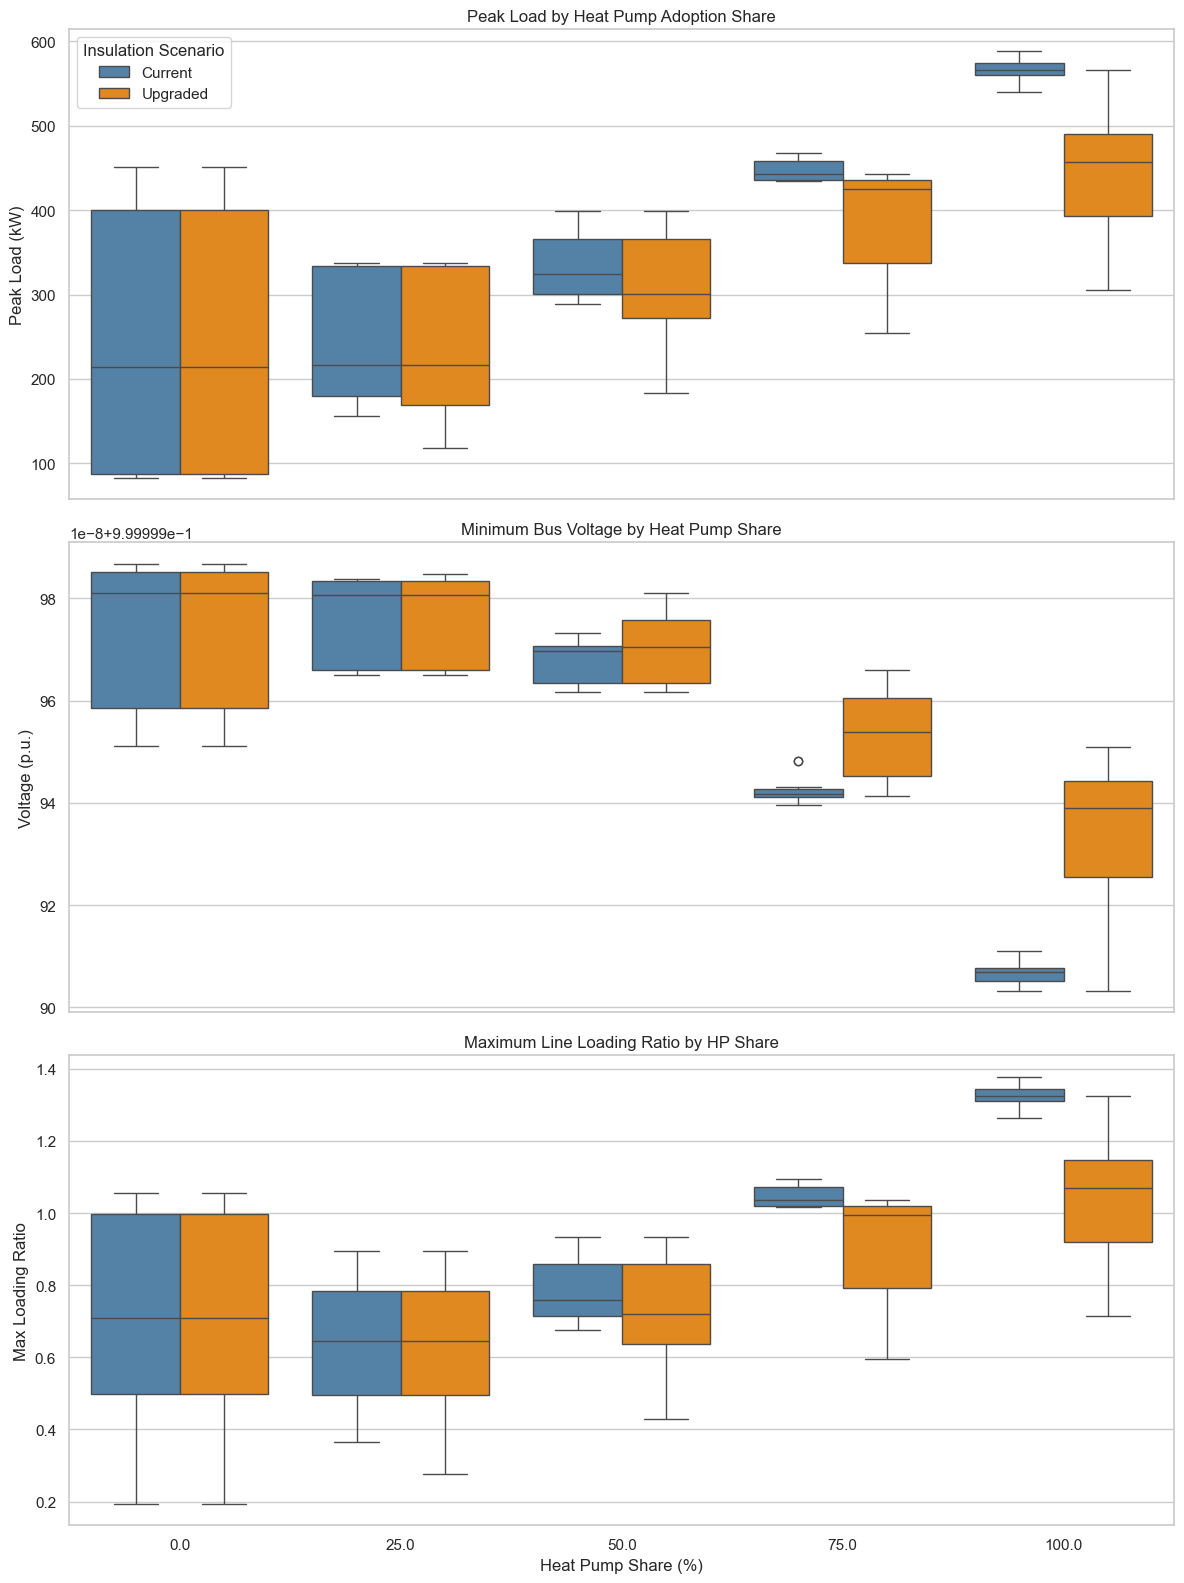

In [114]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load results
df_current = pd.read_csv("Results/lv_grid_results_current.csv")
df_upgraded = pd.read_csv("Results/lv_grid_results_upgraded.csv")

# Label insulation types
df_current["Insulation"] = "Current"
df_upgraded["Insulation"] = "Upgraded"

# Combine both datasets
df_all = pd.concat([df_current, df_upgraded], ignore_index=True)
df_all["HP_share"] = pd.to_numeric(df_all["HP_share"], errors="coerce")


# Convert adoption shares to percentage for clearer axis labels
for col in ["HP_share", "EV_share", "PV_share"]:
    if col in df_all.columns:
        df_all[col] = df_all[col] * 100

# Setup seaborn aesthetics
sns.set(style="whitegrid")

fig, axes = plt.subplots(3, 1, figsize=(12, 16), sharex=True)

# Plot 1: Peak Load vs HP share
sns.boxplot(
    data=df_all,
    x="HP_share",
    y="peak_load_kW",
    hue="Insulation",
    ax=axes[0],
    palette=["steelblue", "darkorange"]
)
axes[0].set_title("Peak Load by Heat Pump Adoption Share")
axes[0].set_ylabel("Peak Load (kW)")
axes[0].legend(title="Insulation Scenario")

# Plot 2: Minimum Voltage (p.u.)
sns.boxplot(
    data=df_all,
    x="HP_share",
    y="min_voltage_pu",
    hue="Insulation",
    ax=axes[1],
    palette=["steelblue", "darkorange"]
)
axes[1].set_title("Minimum Bus Voltage by Heat Pump Share")
axes[1].set_ylabel("Voltage (p.u.)")
axes[1].legend_.remove()

# Plot 3: Max Line Loading Ratio
sns.boxplot(
    data=df_all,
    x="HP_share",
    y="max_loading_ratio",
    hue="Insulation",
    ax=axes[2],
    palette=["steelblue", "darkorange"]
)
axes[2].set_title("Maximum Line Loading Ratio by HP Share")
axes[2].set_ylabel("Max Loading Ratio")
axes[2].legend_.remove()

axes[2].set_xlabel("Heat Pump Share (%)")

plt.tight_layout()

# Save figure
os.makedirs("Results/Plots", exist_ok=True)
plt.savefig("Results/Plots/insulation_comparison_boxplots.png", dpi=300)
plt.show()


In [115]:
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.patches import Patch

def plot_lv_network_4feeders(network, n_feeders=4, houses_per_feeder=40, y_spacing=1.0, title="LV Network with 4 Feeders (40 Houses Each)"):
    G = network.graph()

    # Layout dictionary
    layout = {}

    # Center MV bus above all LV buses
    x_center = (n_feeders + 1) * 2  # adjust horizontal position
    layout["mv_bus"] = (x_center, n_feeders + 3)

    # Place LV buses evenly spaced
    for f in range(1, n_feeders + 1):
        x_pos = f * 4
        lv_bus = f"lv_bus_{f}"
        layout[lv_bus] = (x_pos, n_feeders + 2)

        # Place houses vertically under each LV bus
        for i in range(1, houses_per_feeder + 1):
            house_bus = f"feeder_{f}_house_{i}_bus"
            layout[house_bus] = (x_pos, n_feeders + 1 - i * y_spacing)

    # Assign colors
    node_colors = []
    for node in G.nodes:
        if node == "mv_bus":
            node_colors.append("orange")
        elif node.startswith("lv_bus"):
            node_colors.append("skyblue")
        elif "house" in node:
            node_colors.append("lightgreen")
        else:
            node_colors.append("grey")

    # Legend
    legend_elements = [
        Patch(facecolor='orange', edgecolor='black', label='MV Bus'),
        Patch(facecolor='skyblue', edgecolor='black', label='LV Buses'),
        Patch(facecolor='lightgreen', edgecolor='black', label='Household Buses'),
    ]

    # Draw
    fig, ax = plt.subplots(figsize=(20, 10))
    nx.draw(G, pos=layout, with_labels=False,
            node_color=node_colors, node_size=200,
            edge_color="gray", width=0.6, ax=ax)

    ax.set_title(title, fontsize=14)
    ax.legend(handles=legend_elements, loc="upper right", fontsize=10, frameon=True)
    plt.axis("off")
    plt.show()


NetworkXError: Node 'lv_bus' has no position.

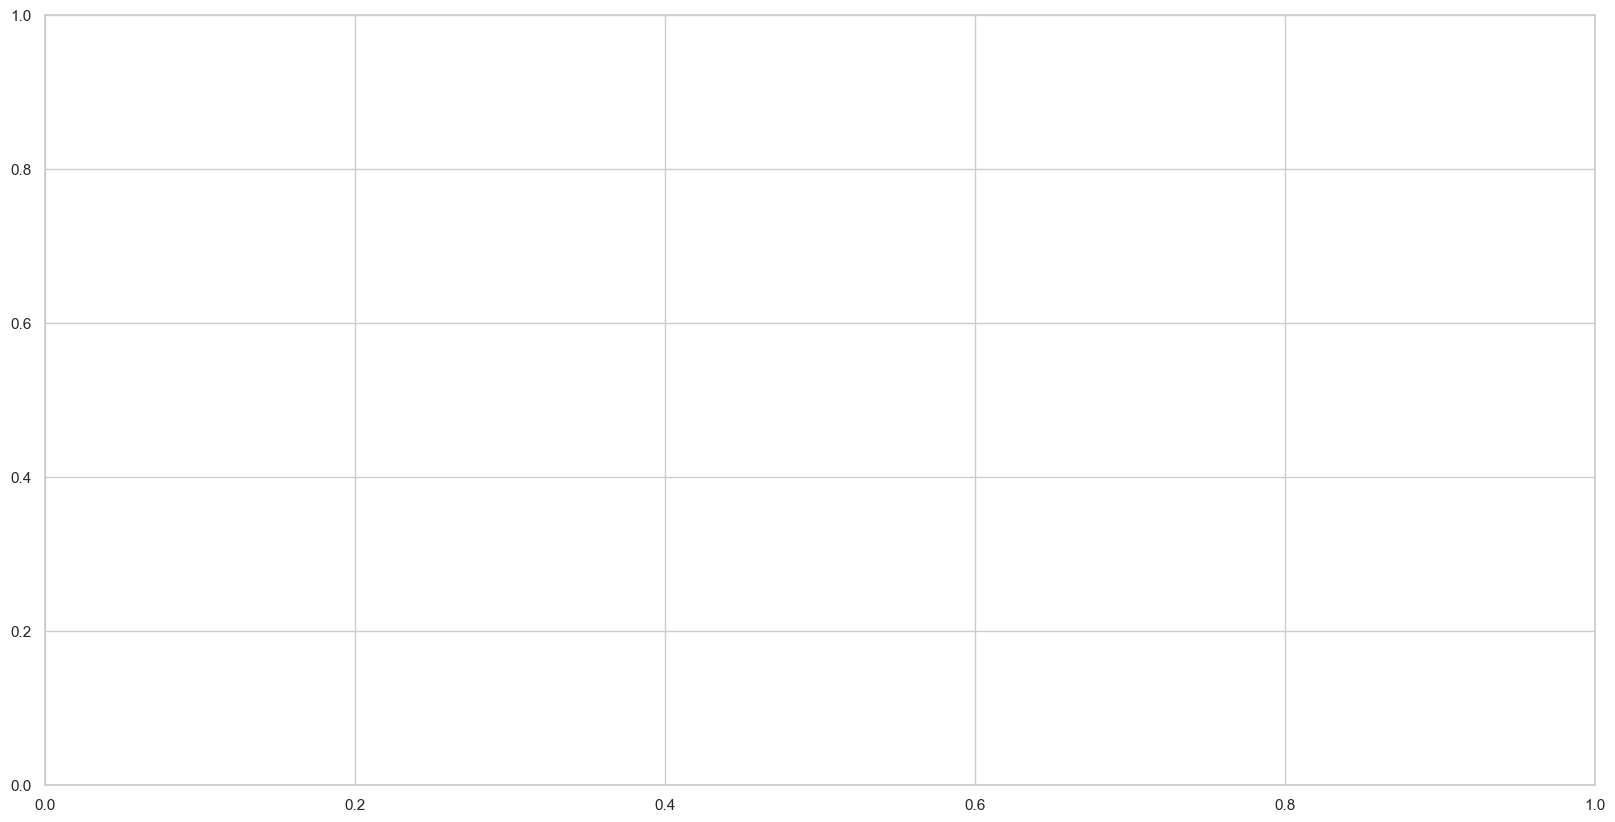

In [116]:
plot_lv_network_4feeders(network, y_spacing=0.3)


In [ ]:
print(network.buses.index.tolist()[:50])  # first 50 bus names


In [ ]:
# After network.pf()
print(network.buses_t.v_mag_pu.head())
print(network.buses_t.v_mag_pu.describe())


In [ ]:
min_v = network.buses_t.v_mag_pu.min().min()
max_v = network.buses_t.v_mag_pu.max().max()
print(f"Voltage range across all buses: {min_v:.4f} – {max_v:.4f} p.u.")
